# **Abdullah Kamal**
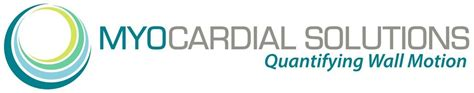

# Oxford-IIIT Pet Classification with Data Augmentation  
This notebook implements a deep learning model for pet classification using the Oxford-IIIT dataset
Key improvements include **data augmentation** and **fine-tuning** for better generalization

In [32]:
# necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [33]:
import os

In [34]:
#personal path on my Laptop
BASE_DIR = r"C:\Users\HP Zbook 17 G6\Desktop\RD\oxford-iiit-pet\images" 
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "validation")
TEST_DIR = os.path.join(BASE_DIR, "test")

# image properties
IMG_SIZE = 224  # image size for resizing
BATCH_SIZE = 32  # batch size for training
NUM_CLASSES = 35  # number of classes in the dataset

assert os.path.exists(TRAIN_DIR), "Training directory not found!"
assert os.path.exists(VAL_DIR), "Validation directory not found!"
assert os.path.exists(TEST_DIR), "Test directory not found!"
print("Dataset paths set correctly")


Dataset paths set correctly


## Data Augmentation
To improve model generalization, we will apply data augmentation to the training dataset
This includes transformations such as rotation, zoom, flipping, and shifting

Data Augmentation is a technique used to artificially expand the training dataset by applying various transformations to existing images. These transformations create variations that help the model generalize better to unseen data, reducing overfitting

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [36]:
# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,          # Normalize pixel values
    rotation_range=30,        # Rotate images up to 30 degrees
    width_shift_range=0.2,    # Shift width by 20%
    height_shift_range=0.2,   # Shift height by 20%
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Flip images horizontally
    fill_mode="nearest"       # Fill in missing pixels
)

# note that there is no augmentation for validation and test sets (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Important: Don't shuffle test data
)

print("Data Augmentation Applied Successfully")

Found 4892 images belonging to 35 classes.
Found 1049 images belonging to 35 classes.
Found 1049 images belonging to 35 classes.
Data Augmentation Applied Successfully


## Visualizing Augmented Images
To ensure data augmentation is applied correctly, we will visualize a few randomly transformed images
from the training dataset. These should show variations like rotation, flipping, zooming, and shifting

In [37]:
import matplotlib.pyplot as plt
import numpy as np

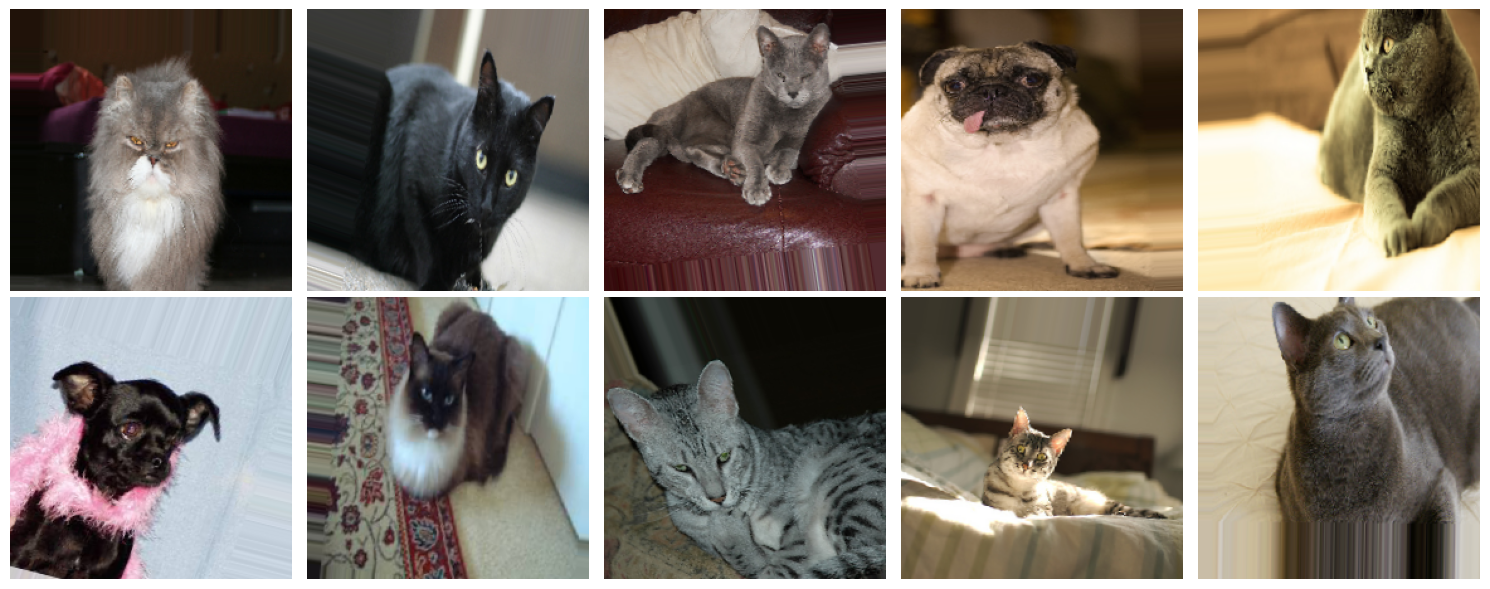

In [38]:
# a batch of augmented images
augmented_images, _ = next(train_generator)  # extract only images, ignore labels

# show a few augmented images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for img, ax in zip(augmented_images[:10], axes):  
    ax.imshow(img)
    ax.axis("off")  # Hide axes

plt.tight_layout()
plt.show()

## load Pre-trained MobileNetV2 Model
We use MobileNetV2 as the base model, pre-trained on ImageNet. The base model is frozen, and we add a custom classifier to adapt it for our 35-class dataset

In [39]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [40]:

# MobileNetV2 pre-trained on ImageNet without the top layer
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model layers
base_model.trainable = False

# a custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(128, activation="relu")(x)  #FC alyer
x = Dropout(0.3)(x)  # Dropout for regularization
output_layer = Dense(NUM_CLASSES, activation="softmax")(x)  # Output layer

# the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# compiling
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [41]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,426,467 (9.26 MB)

 Trainable params: 168,483 (658.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [42]:
# number of fine-tuning epochs
fine_tune_epochs = 10

# Train the model
history_aug = model.fit(
    train_generator,  # Augmented training data
    validation_data=val_generator,  # Validation data
    epochs=fine_tune_epochs,
    verbose=1
)

C:\Users\HP Zbook 17 G6\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.3815 - loss: 2.3458 - val_accuracy: 0.8418 - val_loss: 0.5072
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.7522 - loss: 0.7743 - val_accuracy: 0.8818 - val_loss: 0.4061
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.7920 - loss: 0.6443 - val_accuracy: 0.8827 - val_loss: 0.3709
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.8065 - loss: 0.5868 - val_accuracy: 0.8751 - val_loss: 0.3777
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.8296 - loss: 0.5027 - val_accuracy: 0.8799 - val_loss: 0.3698
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.8398 - loss: 0.4903 - val_accuracy: 0.8866 - val_loss: 0.3440
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.8585 - loss: 0.4256 - val_accuracy: 0.8875 - val_loss: 0.3368
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.8562 - loss: 0.4539 - val_accu

In [43]:
# evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - accuracy: 0.8566 - loss: 0.4520
Test Accuracy: 0.8913
Test Loss: 0.3353


In [44]:
from sklearn.metrics import classification_report

In [45]:
# true labels and predicted labels
true_labels = test_generator.classes  # Actual class labels
predictions = model.predict(test_generator)
predicted_labels = predictions.argmax(axis=1)  # Convert probabilities to class indices

# class names
class_names = list(test_generator.class_indices.keys())

# classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step
                            precision    recall  f1-score   support

                Abyssinian       0.72      0.87      0.79        30
                    Bengal       0.82      0.60      0.69        30
                    Birman       0.79      0.90      0.84        30
                    Bombay       0.86      1.00      0.92        30
         British_Shorthair       0.80      0.93      0.86        30
              Egyptian_Mau       0.90      0.87      0.88        30
                Maine_Coon       0.73      0.90      0.81        30
                   Persian       1.00      0.80      0.89        30
                   Ragdoll       0.73      0.73      0.73        30
              Russian_Blue       0.95      0.70      0.81        30
                   Siamese       0.96      0.87      0.91        30
                    Sphynx       1.00      1.00      1.00        30
          american_bulldog       0.76      0.83      0.79        30
 amer

### Classification Report Analysis

The classification report provides detailed metrics for each class in the dataset:

- **Precision**: Measures how many of the predicted labels are actually correct.
- **Recall**: Measures how many actual labels were correctly predicted.
- **F1-score**: Harmonic mean of precision and recall.
- **Support**: The number of samples for each class.

Higher precision and recall values indicate better classification performance

### General Observations

- The overall **accuracy** is **0.89 (89%)**, showing that the model performs well
- The **macro avg** and **weighted avg** values are also 0.9 for precision and 0.89 for recall and f1 score, confirming stable performance across classes
- Some classes like **Persian, Siamese, and Sphynx** have nearly perfect scores, meaning they are well-classified
- Some classes like **Bengal and American Pit Bull Terrier** have lower recall values, indicating more misclassifications
- The model performs consistently across most categories, suggesting that **data augmentation improved generalization**

### Confusion Matrix Interpretation

The confusion matrix helps visualize model performance by showing:

- **Diagonal values**: Correct classifications (true positives)
- **Off-diagonal values**: Misclassifications (false positives and false negatives)
- **Darker diagonal cells** indicate strong correct classification, while lighter non-diagonal cells suggest misclassifications

It provides insight into **which classes are frequently confused**, guiding potential improvements


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

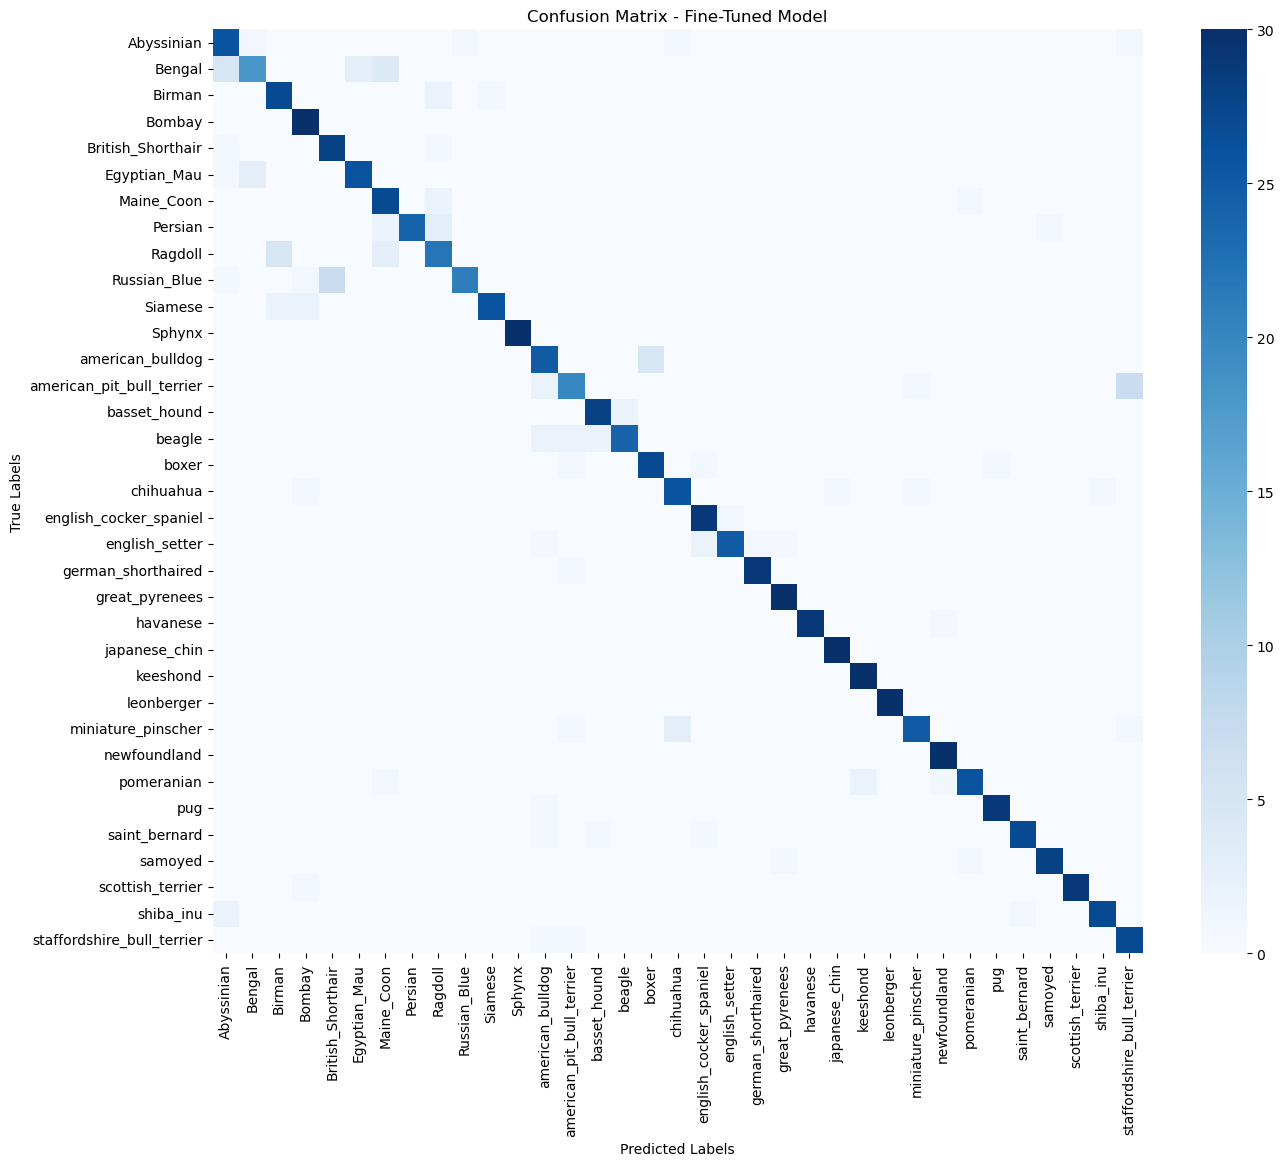

In [47]:
#  the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Fine-Tuned Model")
plt.show()

### Key Observations from the Confusion Matrix

- The majority of predictions **fall along the diagonal**, meaning the model is performing well.
- Some **misclassifications** are noticeable in lighter off-diagonal cells.
- Common misclassifications may occur between similar-looking breeds (e.g., Bengal vs. Bombay).
- Certain categories like **Sphynx and Siamese** show almost perfect classification, while others like **Bengal** have more misclassifications.

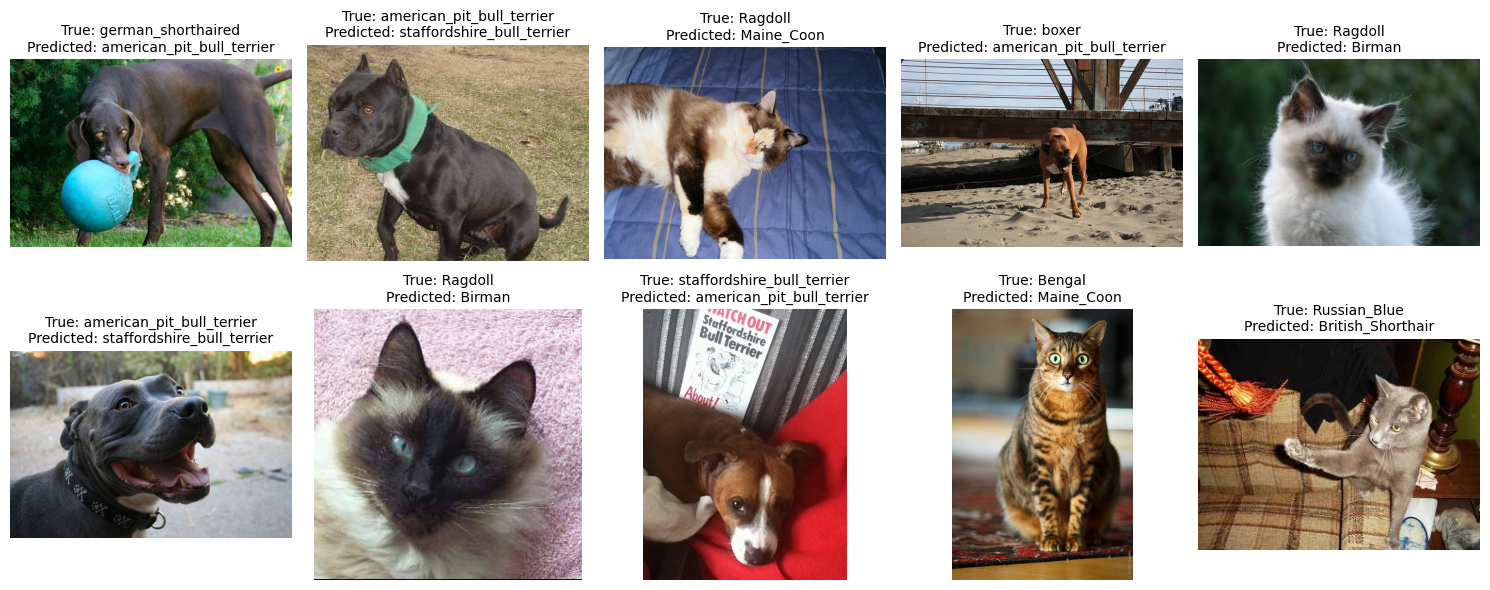

In [48]:
# mapping from class indices to class labels
class_indices = test_generator.class_indices  # Get class mapping
index_to_label = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Identify misclassified indices
misclassified_indices = np.where(true_labels != predicted_labels)[0]

# Select a few misclassified images
num_images = min(10, len(misclassified_indices))  # Show up to 10 misclassified images
misclassified_samples = np.random.choice(misclassified_indices, num_images, replace=False)

# Display misclassified images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, idx in enumerate(misclassified_samples):
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)
    true_label = index_to_label[true_labels[idx]]
    predicted_label = index_to_label[predicted_labels[idx]]

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}", fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

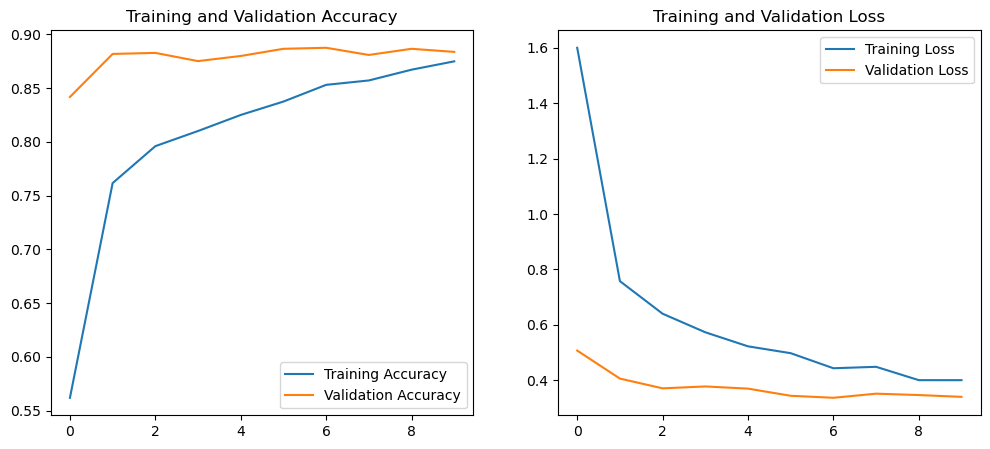

In [49]:
# training and validation accuracy/loss
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(len(acc))

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### saving the trained model

In [50]:
model.save("mobilenetv2_augmented_finetuned.h5")
print("done")

done


### testing the saved model

In [51]:
from tensorflow.keras.models import load_model

In [52]:
# loading the saved model
model = load_model("mobilenetv2_augmented_finetuned.h5")
print("Model loaded")

Model loaded


In [53]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

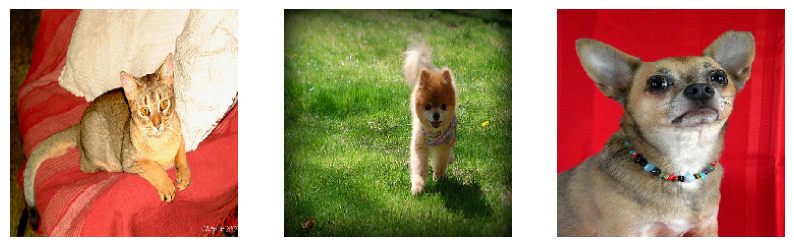

Test images loaded and preprocessed successfully!


In [54]:
# Function to load and preprocess an image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Select test images dynamically
TEST_CATEGORIES = ["Abyssinian", "pomeranian", "chihuahua"]  # Example categories

test_image_paths = []
for category in TEST_CATEGORIES:
    category_path = os.path.join(TEST_DIR, category)
    if os.path.exists(category_path):
        test_files = os.listdir(category_path)
        if test_files:
            test_image_paths.append(os.path.join(category_path, test_files[0]))  # Pick first available image

# Load and preprocess the images
test_images = [preprocess_image(img_path) for img_path in test_image_paths]

# Display test images
fig, axes = plt.subplots(1, len(test_images), figsize=(10, 5))
for i, img_path in enumerate(test_image_paths):
    img = image.load_img(img_path, target_size=(224, 224))
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()

print("Test images loaded and preprocessed successfully!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


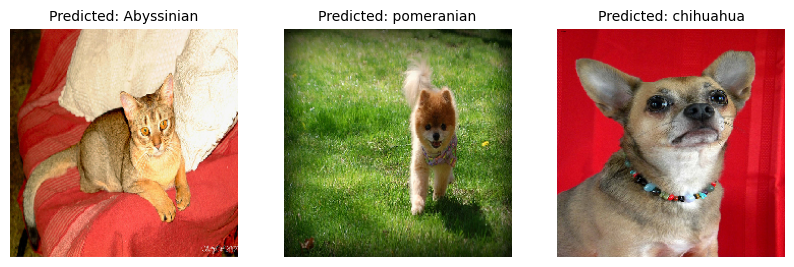

In [55]:
# model predictions
predictions = model.predict(np.vstack(test_images))  # Stack images into a single batch

# convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)  # index of highest probability

# class names from the training data generator
class_labels = list(train_generator.class_indices.keys()) 

# predictions alongside images
fig, axes = plt.subplots(1, len(test_images), figsize=(10, 5))
for i, img_path in enumerate(test_image_paths):
    img = image.load_img(img_path, target_size=(224, 224))
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Predicted: {class_labels[predicted_classes[i]]}", fontsize=10)

plt.show()

### Results Analysis
The model has successfully predicted the classes for the test images:
- Abyssinian
- Pomeranian
- Chihuahua